## Loan Approval Prediction:
In this notebook we explore the prediction of loan approval of an applicant using machine learning. This will be done using the analysis of an applicant's financial history, income, credit rating, employment status, and other relevant attributes. By leveraging historical loan data and applying machine learning algorithms, businesses such as banks can build models to determine loan approvals for new applicants. 

In [3]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import pickle
import os
import joblib
# for modelling
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,precision_recall_curve,f1_score
from sklearn.metrics import confusion_matrix, precision_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import shap

import warnings
warnings.filterwarnings("ignore")

## EDA and Data Processing

In [4]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV file
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data 
train_data = read_data('/data/loan_prediction.csv')

In [5]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'train_data:')
df_snapshot(train_data)

train_data:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'train_data:')
data_types(train_data)

train_data:
<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


In [7]:
train_data['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

The Dependents column has entries of mixed data type ('0', '1', '2', '3+'), we can convert this to integer type and map the "3+" entries to 3 for consistent data type. 

In [8]:
def convert_dependents_column(df, column):
    """
    Converts a 'dependents' column from object type with values '0', '1', '2', '3+' to integer type.
    Values '0', '1', '2' are converted to their respective integers, and '3+' is converted to 3.

    """
    # Mapping for dependents
    mapping = {'0': 0, '1': 1, '2': 2, '3+': 3}
    
    df[column] = df[column].map(mapping).astype(int,errors='ignore')
    
    return df

train_data = convert_dependents_column(train_data, 'Dependents')


In [9]:
## drop the load ID column as this won't be used to train a model

def drop_column(df,column):
    '''
    Drops a column from a dataframe and return df
    '''
    df = df.drop([column], axis=1)
    return df

train_data = drop_column(train_data, 'Loan_ID')

In [10]:
## Check for missing values
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'trin_data:')
null_checker(train_data)

trin_data:
                   Null Count  Null Percentage  Row Count
Credit_History             50         8.143322        614
Self_Employed              32         5.211726        614
LoanAmount                 22         3.583062        614
Dependents                 15         2.442997        614
Loan_Amount_Term           14         2.280130        614
Gender                     13         2.117264        614
Married                     3         0.488599        614
Education                   0         0.000000        614
ApplicantIncome             0         0.000000        614
CoapplicantIncome           0         0.000000        614
Property_Area               0         0.000000        614
Loan_Status                 0         0.000000        614


The data has missing values in some of the columns, we need a way to handle these missing values as many machine learning algorithms fail if the dataset contains missing values.

Fist separate the numetical and categorical features for simple referencing.

In [11]:
def separate_columns(df):
    """
    Separates categorical and numerical columns from a DataFrame.

    """
    numerical_cols = df.select_dtypes(include=['number']).copy()
    categorical_cols = df.select_dtypes(exclude=['number']).copy()
    
    return numerical_cols, categorical_cols

numerical_data, categorical_data = separate_columns(train_data)


In [12]:
numerical_data.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,5849,0.0,NaN,360.0,1.0
1,1.0,4583,1508.0,128.0,360.0,1.0
2,0.0,3000,0.0,66.0,360.0,1.0
3,0.0,2583,2358.0,120.0,360.0,1.0
4,0.0,6000,0.0,141.0,360.0,1.0


In [13]:
categorical_data.head()

,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,Graduate,No,Urban,Y
1,Male,Yes,Graduate,No,Rural,N
2,Male,Yes,Graduate,Yes,Urban,Y
3,Male,Yes,Not Graduate,No,Urban,Y
4,Male,No,Graduate,No,Urban,Y


Before we do missing value imputation let's check the distribution of numerical and categorical features so we can apply an appropriate missing value imputation technique.

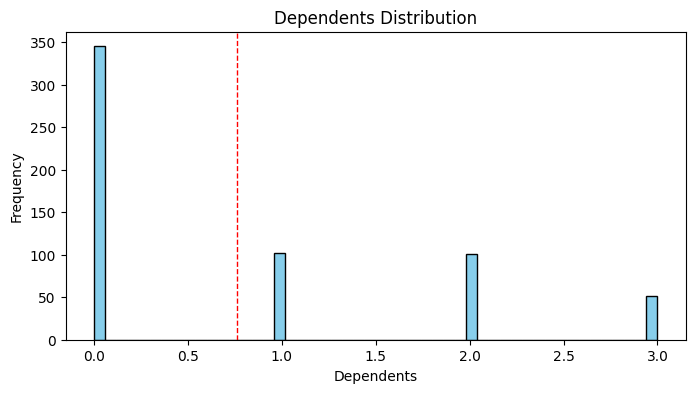

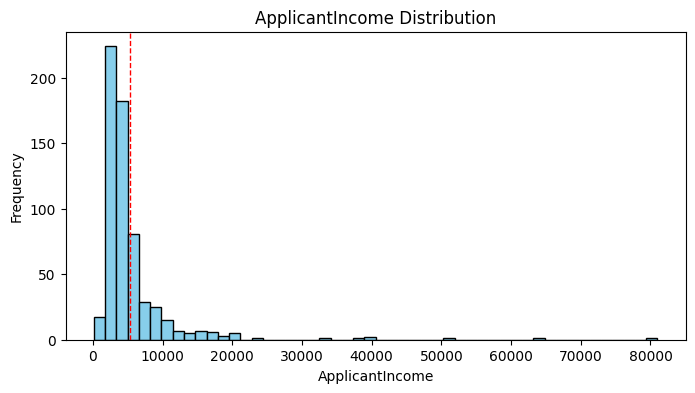

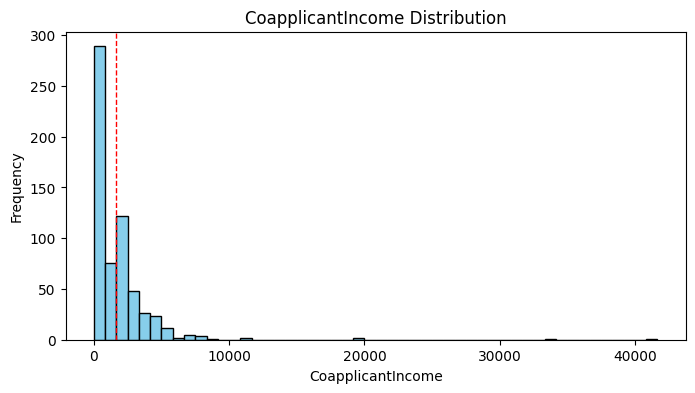

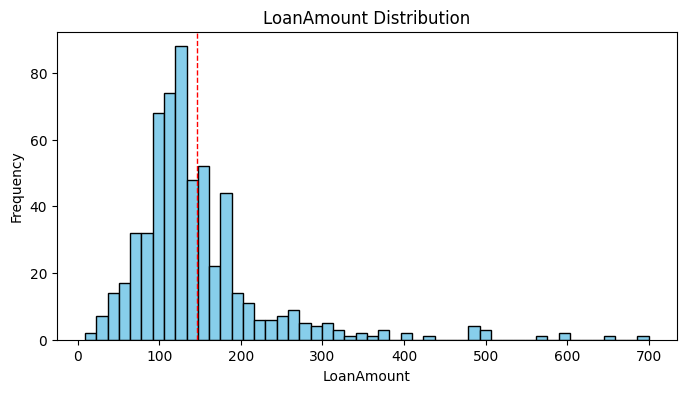

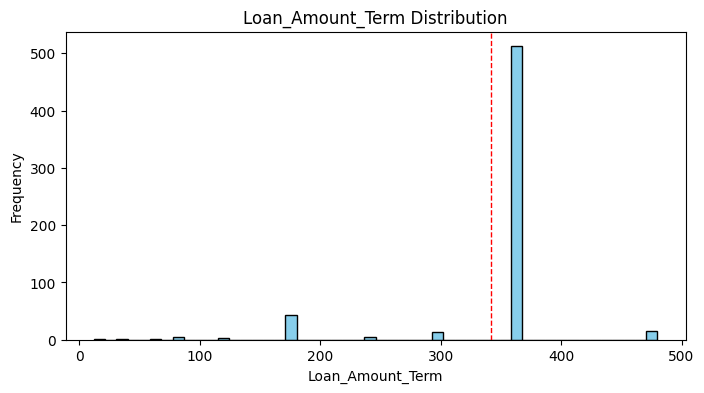

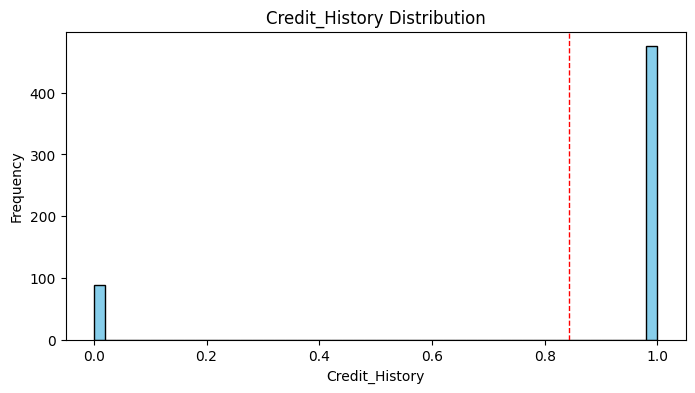

In [14]:
def plot_numerical_distributions(df):
    """
    Plots the distributions of numerical columns in a DataFrame.
    """
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        plt.hist(df[column], bins=50, color='skyblue', edgecolor='black')
        plt.title(f'{column} Distribution')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.show()

plot_numerical_distributions(numerical_data)


### Findings from the distribution
- The LoanAmount IS skewed to the right and containS some outliers. In such cases, the median is generally a better measure of central tendency than the mean because the median is less affected by outliers and skewed data. So we can use the median to impute the missing values of this feature.

In [15]:
def impute_missing_with_median(df, column):
    """
    Imputes missing values in numerical columns with the median.

    """
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)
    
    return df

train_data = impute_missing_with_median(train_data, 'LoanAmount')

We will use the mode imputation for the categorical features (Credit_History, Self_Employed, Dependents, Loan_Amount_Term, Married, Gender) with missing values.
    

In [16]:
def impute_missing_with_mode(df):
        
    # Fill missing values in categorical columns with mode
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)

    return df

train_data = impute_missing_with_mode(train_data)

In [17]:
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


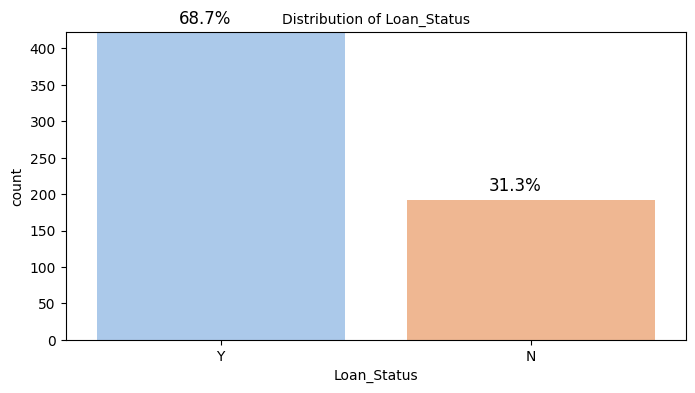

In [18]:
# plot distribution of Loan_Status to check if there's class imbalance or not
plt.figure(figsize=(8, 4))
plt.title("Distribution of Loan_Status", fontsize=10)
plot = sns.countplot(x='Loan_Status', data=train_data, palette='pastel')
plt.ylim(0, train_data['Loan_Status'].value_counts().max() + 1)  

def target(plot):
    total = len(train_data['Loan_Status'])
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')

target(plot)
plt.show()

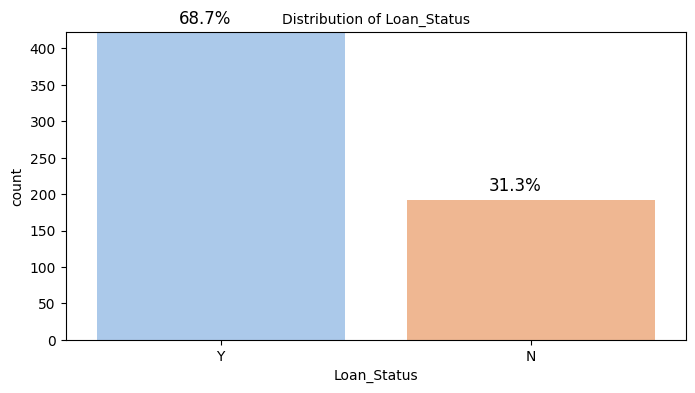

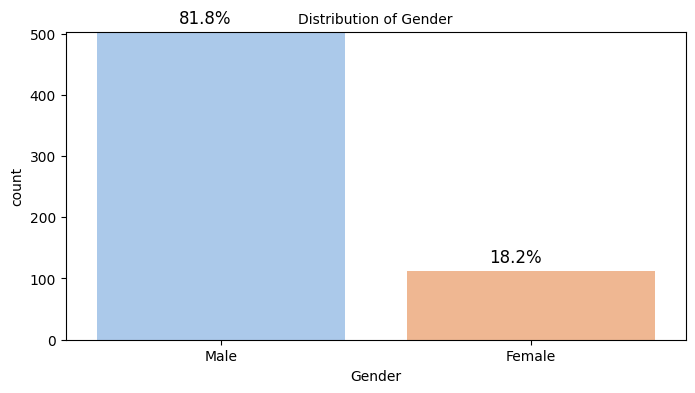

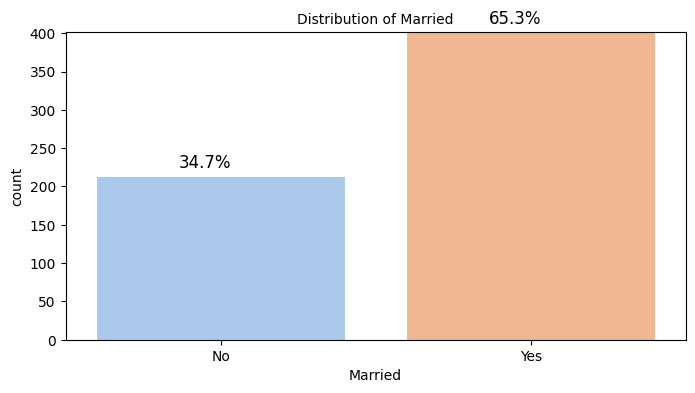

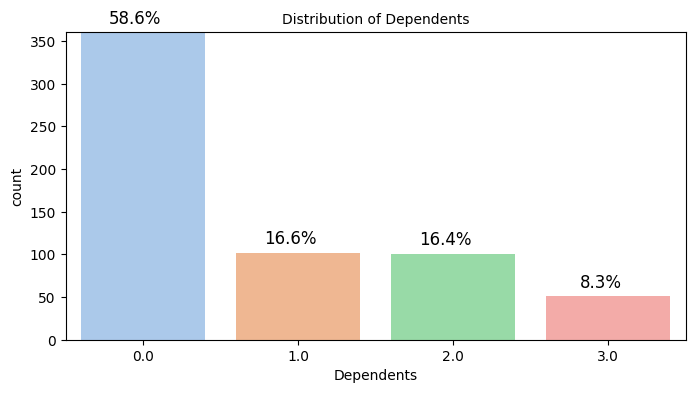

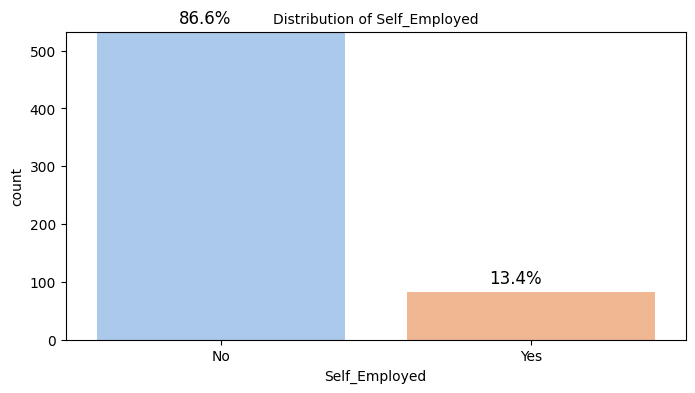

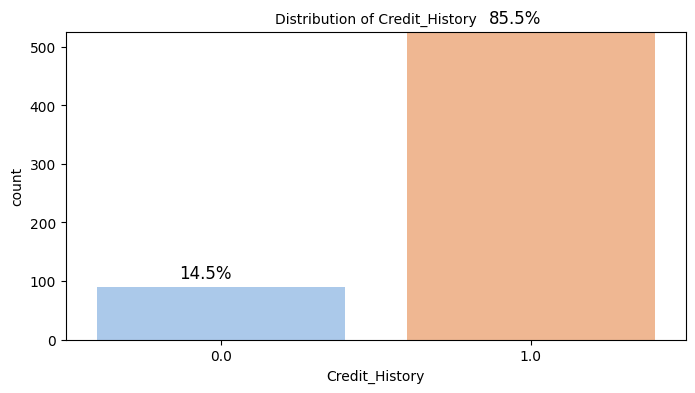

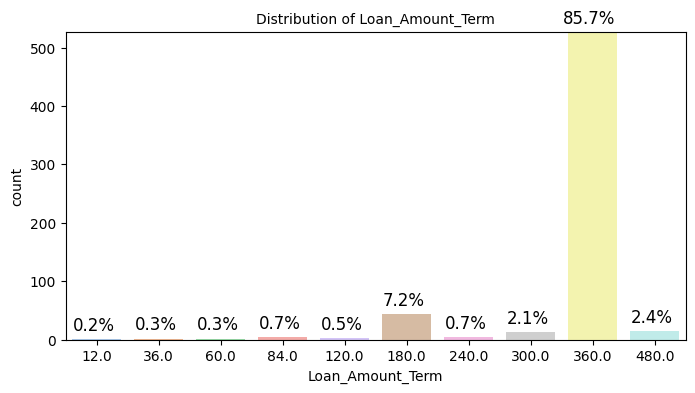

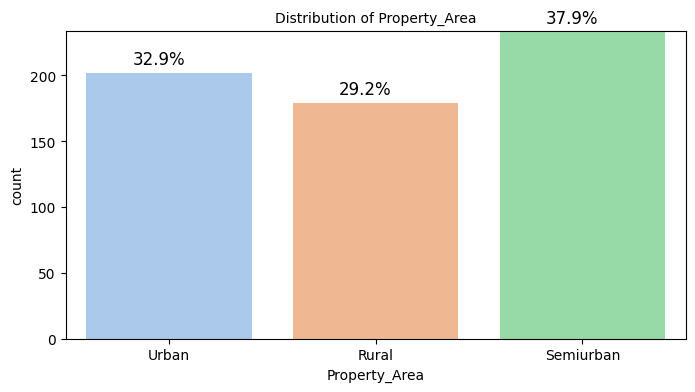

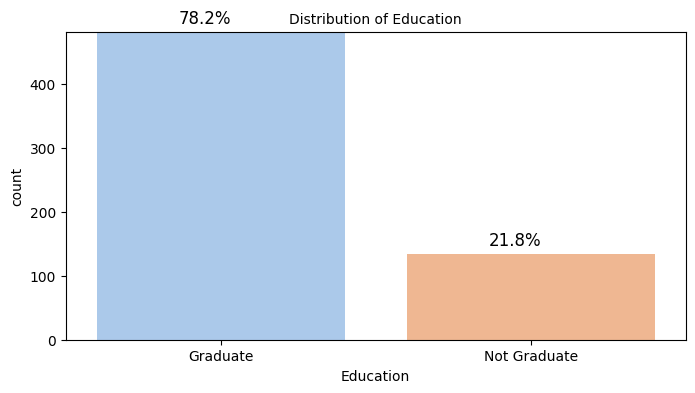

In [19]:
def plot_categorical_distributions(data, columns):
    """
    Plots the distributions of specified categorical columns.

    """
    for column in columns:
        plt.figure(figsize=(8, 4))
        plt.title(f"Distribution of {column}", fontsize=10)
        plot = sns.countplot(x=column, data=data, palette='pastel')
        plt.ylim(0, data[column].value_counts().max() + 1)
        
        total = len(data[column])
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.show()

cat_vars = ['Loan_Status','Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term','Property_Area','Education']
plot_categorical_distributions(train_data, cat_vars)

Insights  
- There is some imbalance in the target variable (Loan_Status), with more loans being approved than not.
- The majority of applicants are male.
- Most loans are taken for 360 months (30 years).
- Most applicants are married.
- A significant portion of applicants have no dependents.
- The majority of applicants are not self-employed.
- Most applicants have a credit history.

### Bivariate analysis

- Now since we are trying to predict the loan status outocme for an applicant, we need to understand understand the relationship between  each of the features and Loan_Status. This will enable us to understand which features tend to predict an applicant who is most likely to be approved. 

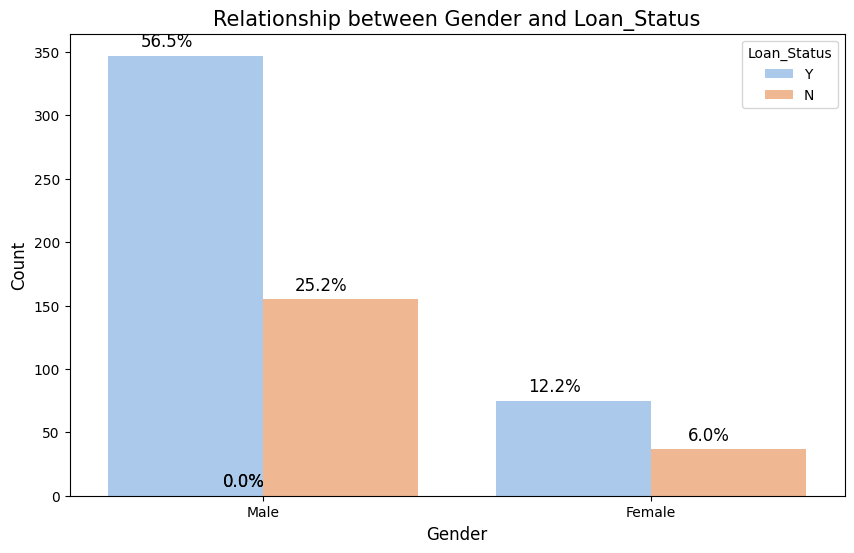

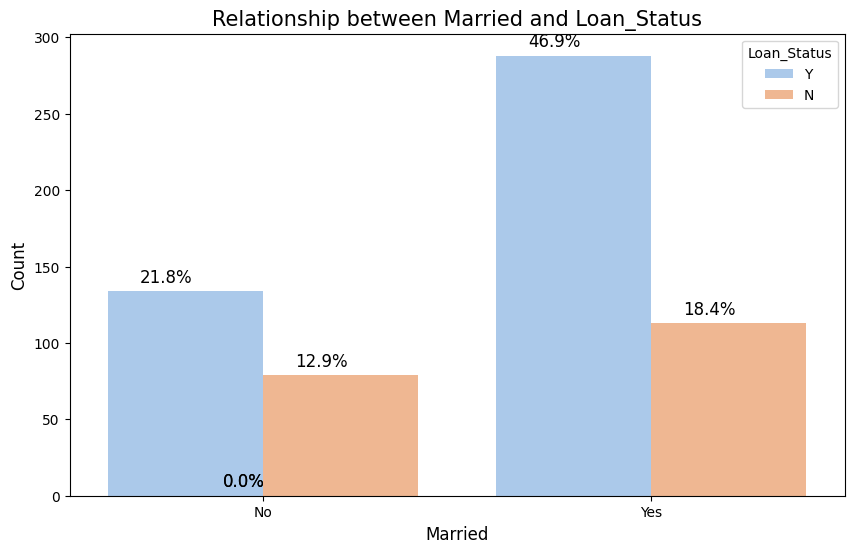

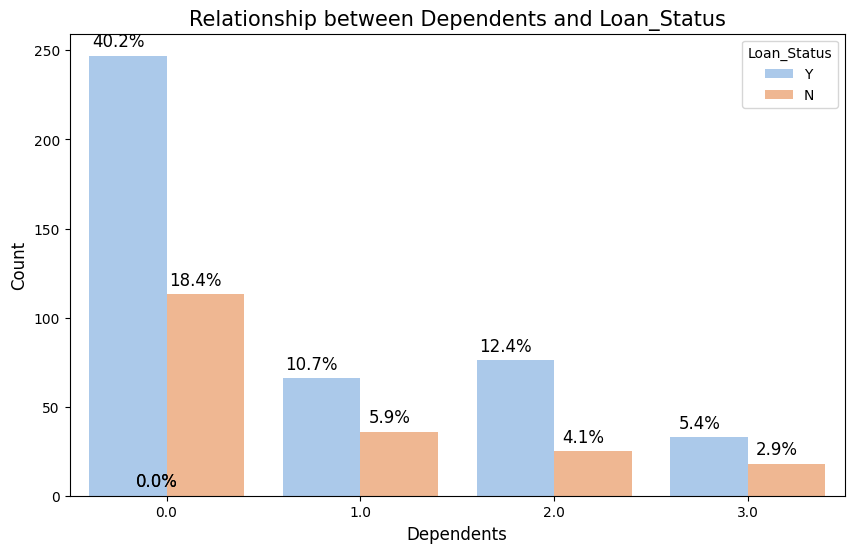

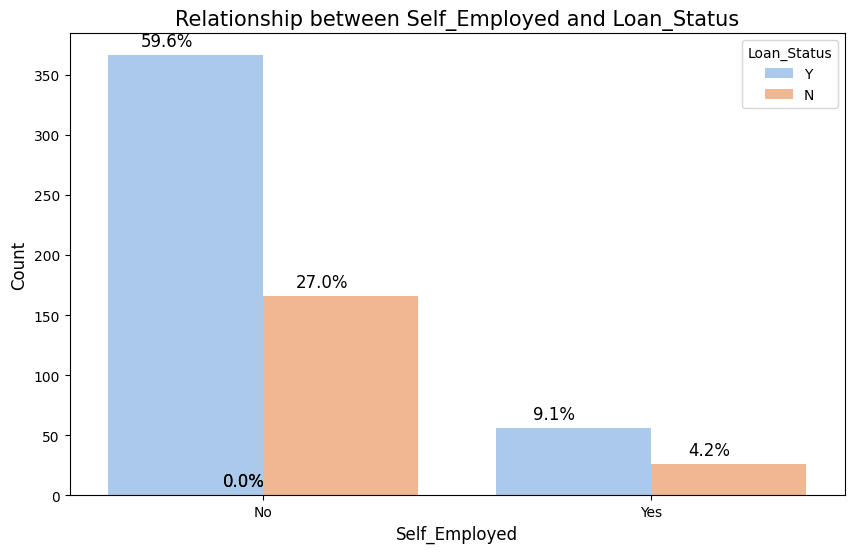

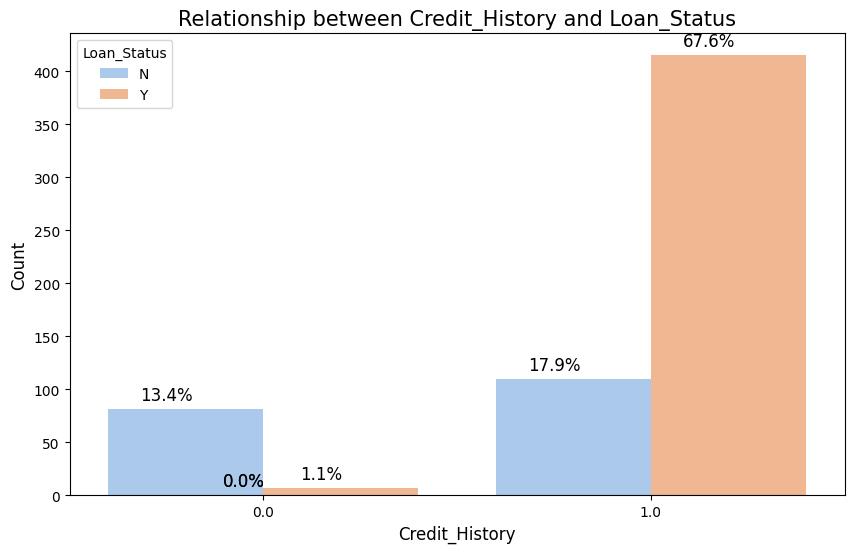

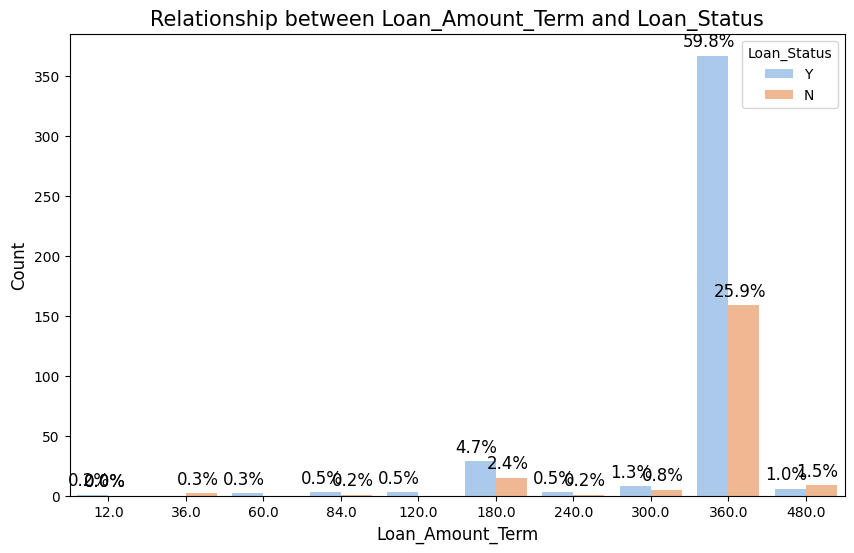

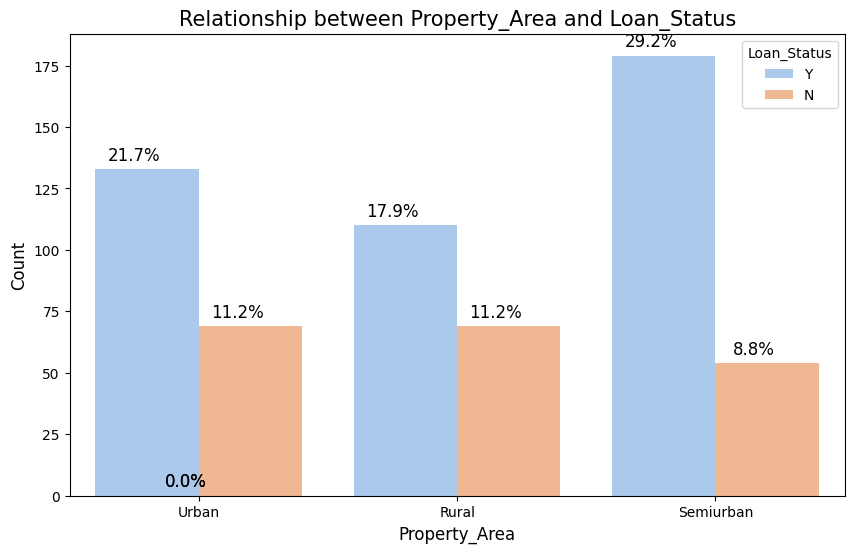

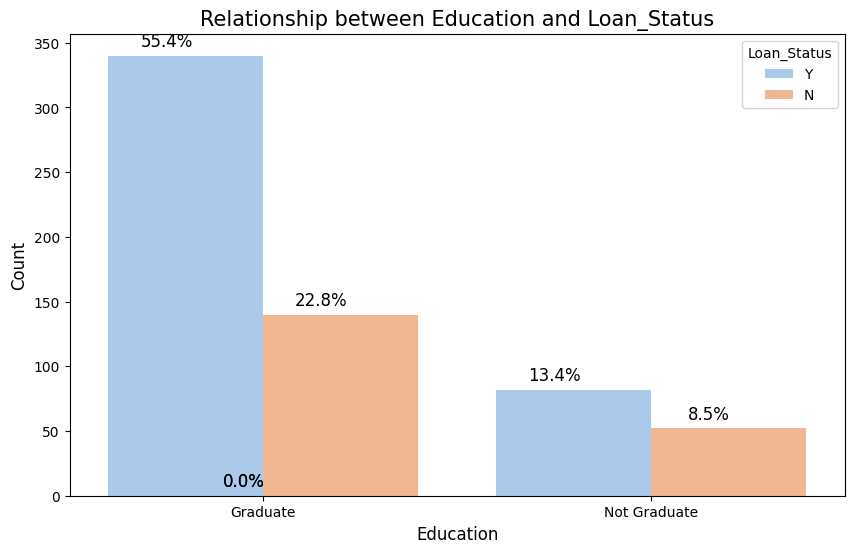

In [20]:
def plot_categorical_relationships_with_loan_status(data, features, target='Loan_Status'):
    """
    Plots the relationship between specified categorical features and the target variable using Seaborn.

    """
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=feature, hue=target, data=data, palette='pastel')
        plt.title(f'Relationship between {feature} and {target}', fontsize=15)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        
        total = len(data)
        for p in plt.gca().patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_height()
            plt.gca().annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.show()

cat_vars = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term','Property_Area','Education']
plot_categorical_relationships_with_loan_status(train_data, cat_vars)


### Insights
- Gender may influence loan approval, with males more likely to be approved.
-  Being married appears to be a positive factor for loan approval, with the majority of approved applicants being married.
- Fewer dependents might correlate with higher loan approval rates.
- Being self-employed seems to be a negative factor for loan approval.
- Applicants with a credit history of 1 (good credit) have a much higher approval rate (67.6%) compared to those with 0 (no credit history) at 1.1%.
- Longer loan terms (360 months) are associated with higher approval rates.
- Applicants from semiurban areas have the highest loan approval rates, while urban and rural areas have similar approval and rejection rates.
- Graduates have a significantly higher loan approval rate compared to non-graduates, indicating that education level may play a crucial role in loan approval

In [21]:
def convert_loan_status(data, column='Loan_Status'):
    """
    Converts the Loan_Status column to numerical values: 'Y' to 1 and 'N' to 0.

    """
    data[column] = data[column].map({'Y': 1, 'N': 0})
    return data

train_data = convert_loan_status(train_data)


In [22]:
def one_hot_encode_columns(data, columns):
    """
    Converts specified categorical columns to numerical using one-hot encoding.

    """
    encoded_data = pd.get_dummies(data, columns=columns)
    # Convert boolean columns to integers (0 and 1)
    for column in encoded_data.columns:
        if encoded_data[column].dtype == 'bool':
            encoded_data[column] = encoded_data[column].astype(int)
    return encoded_data

cat_vars = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History','Property_Area','Education']
train_data_encoded = one_hot_encode_columns(train_data, cat_vars)

### Modelling

In [23]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    X = df.drop(['Loan_Status'], axis=1)
    y = df['Loan_Status']
    
    return X,y
                 
X,y = set_features_and_target(train_data_encoded)
print(X.shape, y.shape)

(614, 21) (614,)


In [24]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(429, 21) (429,)
(185, 21) (185,)


In [25]:
def model_application(X_train,y_train,optimiser):
    # Building model
    '''
    Model application. If optimiser is true , a grid search is applied to optimise the model. 
    If optimiser is false base model is used
            Parameters:
                    X_train : Pandas dataframe of feature set training variables
                    y_train : Pandas dataframe of predictor variable for training set.
                    optimiser : Boolean to indicate optimisation required. 
            Returns:
                    Random Forest model.
    '''
    if optimiser == True:
                # Build the model with K-fold validation and GridSearch to find the best parameters

                # Defining all the parameters
                params = {
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'criterion': ["entropy", "gini"]
                }

                cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=15)

                # Building model
                rf = RandomForestClassifier()

                # Parameter estimating using GridSearch
                grid = GridSearchCV(rf, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
                
                # Fitting the model
                grid.fit(X_train, y_train)

                dtc_grid_val_score = grid.best_score_
                print('Best Score:', dtc_grid_val_score)
                print('Best Params:', grid.best_params_)
                print('Best Estimator:', grid.best_estimator_)

                rf_clf = grid.best_estimator_
    else:
                rf_clf = RandomForestClassifier(n_estimators=150,
                                                max_depth=16,
                                                criterion='gini',
                                                class_weight='balanced',
                                                min_samples_split=10,
                                                max_leaf_nodes=20,
                                                max_features=0.5,
                                                bootstrap=True)
                rf_clf.fit(X_train, y_train)

    return rf_clf

optimiser = False
rf_clf = model_application(X_train,y_train,optimiser)

In [26]:
def model_predict(X_test):
    '''
    Create y_pred , model prediction based on test set features.
            Parameters:
                    X_test (str): Pandas dataframe
            Returns:
                    y_pred
    '''
    y_pred = rf_clf.predict(X_test)
    
    return y_pred

y_pred = model_predict(X_test)
print('Training Accuracy Score(%):',rf_clf.score(X_train,y_train)*100)
print('Test Accuracy Score(%):',rf_clf.score(X_test,y_test)*100)

Training Accuracy Score(%): 91.14219114219114
Test Accuracy Score(%): 78.91891891891892


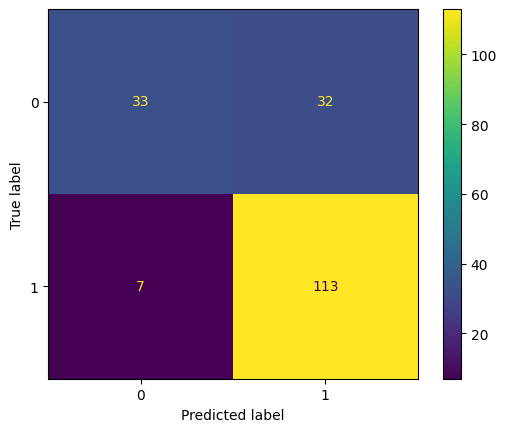

array([[ 33,  32],
       [  7, 113]])

In [27]:
def generate_confusion_matrix(y_test, y_pred):
    '''
    Generates confusion matrix.
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    Y_pred
    '''
    
    cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
    disp.plot()
    plt.grid(False) 
    plt.show()
    
    return cm

generate_confusion_matrix(y_test, y_pred)

In [28]:
def generate_perfomance_metrics(y_test,y_pred):
    '''
    Generates perfomance metrics precision, recall, f1 score, accuracy
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    y_pred
    '''
    rf_model_score = accuracy_score(y_test, y_pred)
    print('Model Accuracy:', rf_model_score)
    return print('Classification Report:\n', classification_report(y_test, y_pred))

generate_perfomance_metrics(y_test,y_pred)

Model Accuracy: 0.7891891891891892
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.51      0.63        65
           1       0.78      0.94      0.85       120

    accuracy                           0.79       185
   macro avg       0.80      0.72      0.74       185
weighted avg       0.80      0.79      0.77       185



### Model performance

#### Strengths:
- Accuracy is decent but not outstanding. It indicates that about 79% of the predictions are correct.
- The model is very good at identifying loans that should be approved (high recall for Class 1).
- The precision for both classes is relatively balanced.

#### Weaknesses:

- The model struggles to correctly identify loans that should not be approved (low recall for Class 0). This leads to many false negatives.
The F1-score for Class 0 is significantly lower than for Class 1, indicating poorer performance in predicting loans that should not be approved.

#### Further improvements
- Class Imbalance: SincecClass 1 (loan approved) is much more frequent than Class 0, we can consider techniques like resampling (over-sampling the minority class or under-sampling the majority class) or using different evaluation metrics like ROC-AUC.
- Feature Engineering: We can look into creating new features or transforming existing ones to better capture the patterns in the data.
- Hyperparameter Tuning: Perform hyperparameter tuning using techniques like grid search or random search to optimize the model parameters i.e setting optimizer=True in the model.
- Algorithm Choice: Experiment with different algorithms to see if a different model performs better.
- Remove outliers: Since some features have outliers, we can remove these or standardize the data.

In [30]:
# save the model
model_save_path = os.path.join('path/to/save/model', 'loan-preds', 'loan_pred_model.pkl')
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
joblib.dump(rf_clf, model_save_path)
print(f"Trained model saved as {model_save_path}")

Trained model saved as Users/mncedisimncwabe/Downloads/loan-preds/rf_clf_model.pkl
